In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.parametrize as parameterize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
Load the data set we will be working with
"""

data_dir = 'Datasets'
dataset_name = 'BioTIME Study 213'
study = 'study_213'
filename = 'top_5_213_linear.csv'

df = pd.read_csv(f'{data_dir}/{study}/{filename}')
df.drop(columns = ['DATE'], inplace = True)
df = (df - df.mean()) / df.std()

train_percent = 80
train_len = int(len(df) * (train_percent / 100))
train = df.head(train_len)
test = df.tail(len(df) - train_len)

print(len(train), len(test))

13145 3287


In [3]:
# the lag is the amount of historical data we provide to the model
lag = 5

adjacency_matrix = np.array([
    [0, 1, 1, 1, 1],
    [1, 0, 1, 1, 1],
    [1, 1, 0, 1, 0],
    [1, 1, 1, 0, 1],
    [1, 1, 0, 1, 0],
])

The general network autoregressive model is:

$$AR(X_t) = \sum_{i = 0}^p \phi_i X_{t - i} + \sum_Y \sum_{i = 0}^p \theta^Y_i Y_{t - i} + \epsilon$$

Where the $\phi_i$ and $\theta_i^Y$ are the learned parameters, $\epsilon$ is noise, and each $Y$ is a neighbor of $X$. For forcasting, we remove the $\epsilon$ and treat the output as the expected value at the next timestep.

In [4]:
from torcheval.metrics.functional import r2_score

class NARModel(nn.Module):

    def __init__(self, lag, adj_mat):
        super().__init__()

        # We will use the adj_mat to determine which linear models need to be applied
        self.adj_mat = adj_mat
        self.channels = len(adj_mat)

        # The basic autoregressive model is simply a linear combination of the last values
        # For the network varient, we will create a matrix of linear models, applying the ones that
        # correspond to edges in the underlying network
        # Note that in reality, each linear model should have lag inputs and only one output, however to simplify
        # working with torch, we allow for self.channels outputs, which will then by multiplied by a vector with exactly
        # one coordinate set to one. This will effectively reduce the number of outputs to one, but will make vector
        # operations in the forward pass easier
        self.model = nn.ModuleList([nn.ModuleList([nn.Linear(lag, self.channels) for _ in range(self.channels)]) for _ in range(self.channels)])

        # store the lag in case we need it
        self.lag = lag

        # store the identity matrix, which is used to simplify the forward pass
        self.eye = torch.eye(self.channels)

    def forward(self, input):
        output = torch.zeros(self.channels)

        for i in range(self.channels):
            # We always apply the auto regressive model to the current node
            output += self.model[i][i](input[i]) * self.eye[i]

            # For each other node, we only apply the model if the nodes are connected
            # in the adjacency matrix
            for j in range(self.channels):
                if self.adj_mat[i][j] == 0 or i == j: continue
                output += self.model[i][j](input[j]) * self.eye[i]

        return output
    
    def fit(self, data, test = None, iters = 100, lr = 0.001, verbose = False):
        self.mse = { 'train' : [], 'test' : [] }
        self.r2 = { 'train' : [], 'test' : [] }
        self.MAE = { 'train' : [], 'test' : [] }

        # We will use 100 iterations of stochastic gradient descent with a learning rate
        # of 0.001
        optimizer = optim.Adam(self.parameters(), lr = lr)

        # Mean Square Error loss
        loss_fn = nn.MSELoss()

        # First generate the sequences of inputs and outputs in the proper tensor format
        input, output = [], []
        for i in range(self.lag, len(data[0])):
            curr_input = []
            curr_output = []
            for j in range(self.channels):
                curr_input.append(data[j][i - self.lag:i])
                curr_output.append(data[j][i])
            input.append(torch.tensor(curr_input, dtype = torch.float32))
            output.append(torch.tensor(curr_output, dtype = torch.float32))

        test_input, test_output = [], []
        if test is not None:
            for i in range(self.lag, len(test[0])):
                curr_input = []
                curr_output = []
                for j in range(self.channels):
                    curr_input.append(data[j][i - self.lag:i])
                    curr_output.append(data[j][i])
                test_input.append(torch.tensor(curr_input, dtype = torch.float32))
                test_output.append(torch.tensor(curr_output, dtype = torch.float32))

        for _ in range(iters):
            total_loss = 0
            predicted = []
            for x, y in zip(input, output):
                # We need to zero the gradients for each optimization step
                optimizer.zero_grad()

                # Calculate the loss for this step
                pred = self.forward(x)
                predicted.append(pred)
                loss = loss_fn(pred, y)
                total_loss += loss

                # Backpropagate the loss
                loss.backward()

                # Step the optimizer forward to update the parameters
                optimizer.step()
            
            self.mse['train'].append(
                sum(nn.functional.mse_loss(p, o) for p, o in zip(torch.stack(predicted).transpose(1, 0), torch.stack(output).transpose(1, 0)))
            )

            self.r2['train'].append(
                sum(r2_score(p, o) for p, o in zip(torch.stack(predicted).transpose(1, 0), torch.stack(output).transpose(1, 0))) / self.channels
            )

            self.MAE['train'].append(
                sum(nn.functional.l1_loss(p, o) for p, o in zip(torch.stack(predicted).transpose(1, 0), torch.stack(output).transpose(1, 0)))
            )

            if verbose: print(f'total loss: {total_loss:.4f}')

            if test is not None:
                predicted = []
                for x, y in zip(test_input, test_output):
                    pred = self.forward(x)
                    predicted.append(pred)
                
                self.mse['test'].append(
                    sum(nn.functional.mse_loss(p, o) for p, o in zip(torch.stack(predicted).transpose(1, 0), torch.stack(test_output).transpose(1, 0)))
                )

                self.r2['test'].append(
                    sum(r2_score(p, o) for p, o in zip(torch.stack(predicted).transpose(1, 0), torch.stack(test_output).transpose(1, 0))) / self.channels
                )

                self.MAE['test'].append(
                    sum(nn.functional.l1_loss(p, o) for p, o in zip(torch.stack(predicted).transpose(1, 0), torch.stack(test_output).transpose(1, 0)))
                )


In [5]:
model = NARModel(lag, adjacency_matrix)

all_data = []
for s in train.columns:
    all_data.append(train[s].tolist())

test_data = []
for s in test.columns:
    test_data.append(test[s].tolist())

model.fit(all_data, test = test_data, verbose=False)

: 

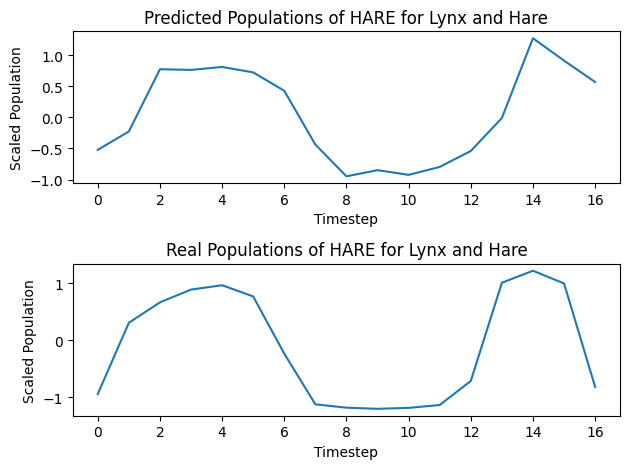

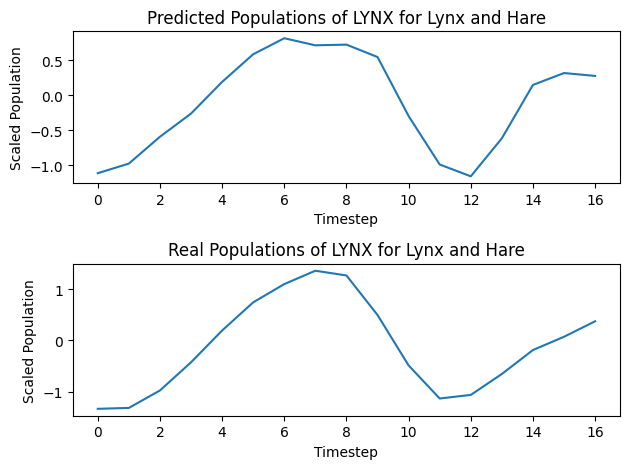

MSE: 0.3637
R2 Score: 0.7879
MAE: 0.6218


In [ ]:
from torcheval.metrics.functional import r2_score

x = [i for i in range(len(test) - lag)]

data = []
for s in test.columns:
    data.append(test[s].tolist())

mse_loss = 0
l1_loss = 0
r2_loss = 0

for s in range(len(data)):
    _, (predicted, real) = plt.subplots(2, sharey = True)
    expected, predictions = [], []
    for i in range(lag, len(test)):
        input = []
        for stream in data:
            input.append(stream[i - lag:i])
        expected.append(data[s][i])
        input = torch.tensor(input, dtype = torch.float32)
        predictions.append(model.forward(input).detach().numpy()[s])

    # Calculate the Mean Square Error for this model
    mse_loss += nn.functional.mse_loss(torch.tensor(predictions), torch.tensor(expected))
    l1_loss += nn.functional.l1_loss(torch.tensor(predictions), torch.tensor(expected))
    r2_loss += r2_score(torch.tensor(predictions), torch.tensor(expected)) / len(data)
        
    predicted.plot(x, predictions)
    predicted.title.set_text(f'Predicted Populations of {test.columns[s]} for {dataset_name}')
    predicted.set_xlabel('Timestep')
    predicted.set_ylabel('Scaled Population')
    real.plot(x, expected)
    real.title.set_text(f'Real Populations of {test.columns[s]} for {dataset_name}')
    real.set_xlabel('Timestep')
    real.set_ylabel('Scaled Population')
    plt.tight_layout()
    plt.show()

print(f'MSE: {mse_loss:.4f}')
print(f'R2 Score: {r2_loss:.4f}')
print(f'MAE: {l1_loss:.4f}')

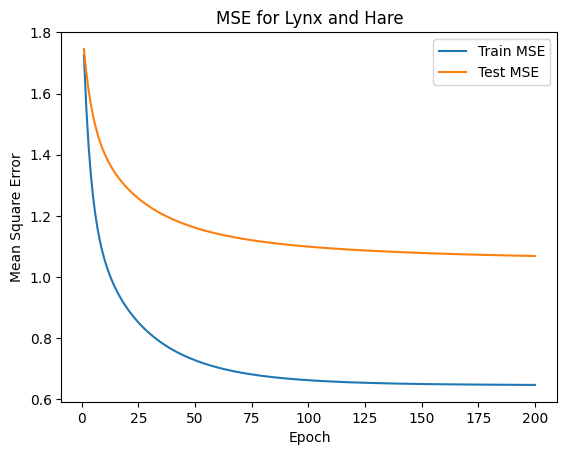

In [ ]:
plt.plot(range(1, 201), [t.item() for t in model.mse['train']], label = 'Train MSE')
plt.plot(range(1, 201),[t.item() for t in model.mse['test']], label = 'Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.title(f'MSE for {dataset_name}')
plt.legend()
plt.show()

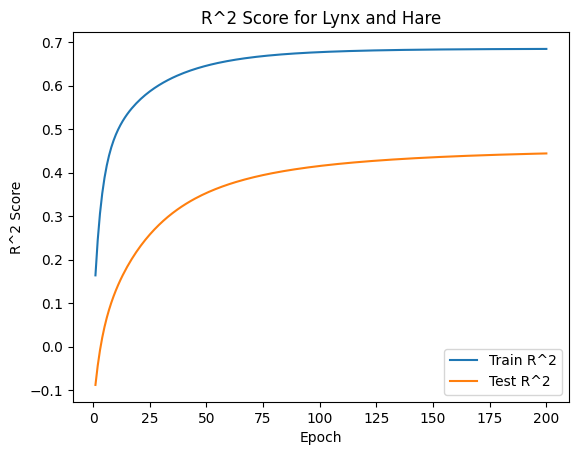

In [ ]:
plt.plot(range(1, 201), [t.item() for t in model.r2['train']], label = 'Train R^2')
plt.plot(range(1, 201),[t.item() for t in model.r2['test']], label = 'Test R^2')
plt.xlabel('Epoch')
plt.ylabel('R^2 Score')
plt.title(f'R^2 Score for {dataset_name}')
plt.legend()
plt.show()

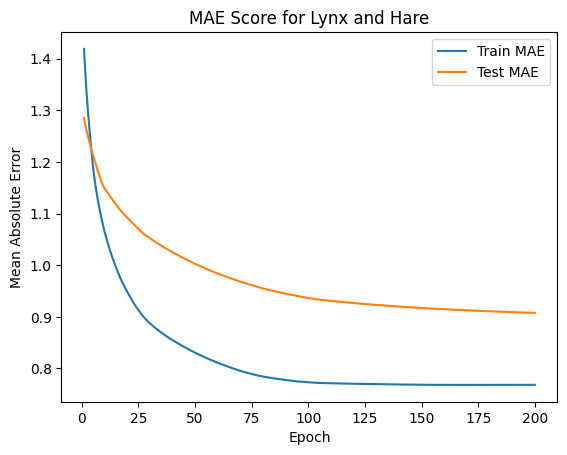

In [ ]:
plt.plot(range(1, 201), [t.item() for t in model.MAE['train']], label = 'Train MAE')
plt.plot(range(1, 201),[t.item() for t in model.MAE['test']], label = 'Test MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title(f'MAE Score for {dataset_name}')
plt.legend()
plt.show()